# 获取数据

## 源数据
price: https://studio.glassnode.com/metrics?a=ETH&category=&ema=0&m=market.PriceUsdOhlc&mAvg=0&mMedian=0&s=1488326400&u=1709222399&zoom=

nvt ratio: https://studio.glassnode.com/metrics?a=ETH&category=&ema=0&m=indicators.Nvt&mAvg=0&mMedian=0&s=1488326400&u=1709222399&zoom=

## 训练集&测试集(取一半)：

2017.3.1 - 2024.2.29

## 回测：

2019.7.9 - 2024.2.29

In [43]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

### 读取price数据

In [44]:
df = pd.read_csv('../data/eth_price.csv')
df.drop(df.columns[1], axis=1, inplace=True)
df.columns = ['date', 'close', 'high', 'low', 'open']
df['date'] = pd.to_datetime(df['date'])
df = df[(df['date'] >= '2017-03-01') & (df['date'] <= '2024-02-29')]
df

,date,close,high,low,open
0,2017-03-01,17.758000,17.758000,16.970000,16.970000
1,2017-03-02,19.208000,19.246000,19.144000,19.144000
2,2017-03-03,19.610000,20.040000,19.610000,20.040000
3,2017-03-04,18.702000,18.900000,18.660000,18.834000
4,2017-03-05,19.200000,19.200000,19.150000,19.152000
...,...,...,...,...,...
2552,2024-02-25,3111.157214,3113.612582,3099.943825,3104.313420
2553,2024-02-26,3179.377544,3182.628043,3171.625989,3182.459859
2554,2024-02-27,3243.107970,3250.021864,3240.807238,3250.021864
2555,2024-02-28,3381.199751,3382.843713,3343.736769,3343.736769


### 读取nvt ratio数据

In [45]:
df_nvt = pd.read_csv('../data/ethereum-network-value-to-transactions-ratio-nvt.csv')
df_nvt.columns = ['date', 'nvt ratio']
df_nvt['date'] = pd.to_datetime(df['date'])
df_nvt = df_nvt[(df_nvt['date'] >= '2017-03-01') & (df_nvt['date'] <= '2024-02-29')]
df_nvt

,date,nvt ratio
0,2017-03-01,7.576159
1,2017-03-02,5.164297
2,2017-03-03,5.427846
3,2017-03-04,8.371288
4,2017-03-05,9.768700
...,...,...
2552,2024-02-25,107.155343
2553,2024-02-26,66.200709
2554,2024-02-27,58.230598
2555,2024-02-28,54.721723


### 合并数据

In [46]:
df['NVT'] = df_nvt['nvt ratio']
df['NVT'] = df['NVT'].fillna(method='ffill')
df.to_csv('../data/input.csv')
df.set_index(['date'], inplace = True, drop=True) 
list_feature = list(df.columns)
print(list_feature)
df

['close', 'high', 'low', 'open', 'NVT']


,close,high,low,open,NVT
date,,,,,
2017-03-01,17.758000,17.758000,16.970000,16.970000,7.576159
2017-03-02,19.208000,19.246000,19.144000,19.144000,5.164297
2017-03-03,19.610000,20.040000,19.610000,20.040000,5.427846
2017-03-04,18.702000,18.900000,18.660000,18.834000,8.371288
2017-03-05,19.200000,19.200000,19.150000,19.152000,9.768700
...,...,...,...,...,...
2024-02-25,3111.157214,3113.612582,3099.943825,3104.313420,107.155343
2024-02-26,3179.377544,3182.628043,3171.625989,3182.459859,66.200709
2024-02-27,3243.107970,3250.021864,3240.807238,3250.021864,58.230598


# 多因子LSTM预测模型

### 特征归一化

拟合操作将计算数据的最小值和最大值，然后对数据进行缩放转换，使其落入指定的范围

缩放后的数据被存储在变量scaled中

In [47]:
values = df
values = values.astype('float32')

# Create a MinMaxScaler object to scale the data to (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform operations on values using MinMaxScaler objects
scaled = scaler.fit_transform(values)

scaled

array([[2.4529244e-04, 1.4494103e-04, 9.8947203e-05, 0.0000000e+00,
        1.1193836e-02],
       [5.4722326e-04, 4.5481557e-04, 5.5663171e-04, 4.5626750e-04,
        6.3341926e-03],
       [6.3093100e-04, 6.2016491e-04, 6.5473723e-04, 6.4431550e-04,
        6.8652160e-03],
       ...,
       [6.7185313e-01, 6.7325997e-01, 6.7880189e-01, 6.7853564e-01,
        1.1325711e-01],
       [7.0060766e-01, 7.0091999e-01, 7.0047134e-01, 6.9820404e-01,
        1.0618710e-01],
       [7.1808356e-01, 7.2158784e-01, 7.2548938e-01, 7.2342026e-01,
        1.3153352e-01]], dtype=float32)

### 将数据集转换为监督学习问题

In [48]:
from pandas import DataFrame
from pandas import concat

# Converting time series data into the format of a supervised learning problem
def series_to_supervised(data, list_feature, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    # Used to store feature columns and corresponding names
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(list_feature[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(list_feature[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(list_feature[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

n_in = 3  #Use features from the last number of days as input
n_out = 2  #Forecast prices for the next few days
# frame as supervised learning
reframed = series_to_supervised(scaled, list_feature, n_in, n_out)
reframed

,close(t-3),high(t-3),low(t-3),open(t-3),NVT(t-3),close(t-2),high(t-2),low(t-2),open(t-2),NVT(t-2),...,close(t),high(t),low(t),open(t),NVT(t),close(t+1),high(t+1),low(t+1),open(t+1),NVT(t+1)
3,0.000245,0.000145,0.000099,0.000000,0.011194,0.000547,0.000455,0.000557,0.000456,0.006334,...,0.000442,0.000383,0.000455,0.000391,0.012796,0.000546,0.000445,0.000558,0.000458,0.015612
4,0.000547,0.000455,0.000557,0.000456,0.006334,0.000631,0.000620,0.000655,0.000644,0.006865,...,0.000546,0.000445,0.000558,0.000458,0.015612,0.000706,0.000619,0.000728,0.000643,0.007703
5,0.000631,0.000620,0.000655,0.000644,0.006865,0.000442,0.000383,0.000455,0.000391,0.012796,...,0.000706,0.000619,0.000728,0.000643,0.007703,0.000494,0.000439,0.000516,0.000424,0.013326
6,0.000442,0.000383,0.000455,0.000391,0.012796,0.000546,0.000445,0.000558,0.000458,0.015612,...,0.000494,0.000439,0.000516,0.000424,0.013326,0.000000,0.000000,0.000000,0.000004,0.011965
7,0.000546,0.000445,0.000558,0.000458,0.015612,0.000706,0.000619,0.000728,0.000643,0.007703,...,0.000000,0.000000,0.000000,0.000004,0.011965,0.000296,0.000248,0.000316,0.000269,0.008067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,0.615244,0.616486,0.615865,0.613859,0.140233,0.615002,0.618918,0.621808,0.623769,0.153868,...,0.619526,0.619602,0.625160,0.623163,0.274342,0.644377,0.644853,0.649146,0.647955,0.211835
2552,0.615002,0.618918,0.621808,0.623769,0.153868,0.604987,0.606381,0.608755,0.609593,0.194444,...,0.644377,0.644853,0.649146,0.647955,0.211835,0.658583,0.659225,0.664237,0.664356,0.129316
2553,0.604987,0.606381,0.608755,0.609593,0.194444,0.619526,0.619602,0.625160,0.623163,0.274342,...,0.658583,0.659225,0.664237,0.664356,0.129316,0.671853,0.673260,0.678802,0.678536,0.113257
2554,0.619526,0.619602,0.625160,0.623163,0.274342,0.644377,0.644853,0.649146,0.647955,0.211835,...,0.671853,0.673260,0.678802,0.678536,0.113257,0.700608,0.700920,0.700471,0.698204,0.106187


### 拆分为输入矩阵和输出矩阵

根据给定的时间步长（n_in 和 n_out）以及特征名称（list_feature），构造输入特征（X）和目标变量（Y）的列名列表

并从 reframed 中选择对应的列作为输入和输出

t-3, t-2, ..., t-1 是过去3天的实际数据

t, t+1 是预测数据

In [49]:
print(reframed.columns)
list_use_feature = []
for j in range(len(list_feature)):
    for i in range(n_in):
        list_use_feature.append(list_feature[j]+'(t-%d)' % (i+1))
    
X = reframed[list_use_feature]
print('X columns: ',X.columns)

list_use_result = []
list_use_result.append('close(t)')
for i in range(n_out-1):
    list_use_result.append('close(t+%d)' % (i+1))
Y = reframed[list_use_result]
print('Y column: ', Y.columns)


Index(['close(t-3)', 'high(t-3)', 'low(t-3)', 'open(t-3)', 'NVT(t-3)',
       'close(t-2)', 'high(t-2)', 'low(t-2)', 'open(t-2)', 'NVT(t-2)',
       'close(t-1)', 'high(t-1)', 'low(t-1)', 'open(t-1)', 'NVT(t-1)',
       'close(t)', 'high(t)', 'low(t)', 'open(t)', 'NVT(t)', 'close(t+1)',
       'high(t+1)', 'low(t+1)', 'open(t+1)', 'NVT(t+1)'],
      dtype='object')
X columns:  Index(['close(t-1)', 'close(t-2)', 'close(t-3)', 'high(t-1)', 'high(t-2)',
       'high(t-3)', 'low(t-1)', 'low(t-2)', 'low(t-3)', 'open(t-1)',
       'open(t-2)', 'open(t-3)', 'NVT(t-1)', 'NVT(t-2)', 'NVT(t-3)'],
      dtype='object')
Y column:  Index(['close(t)', 'close(t+1)'], dtype='object')


### 拆分为训练集和测试集

将输入特征（X）和目标变量（Y）转换为适合在神经网络中使用的格式，并划分训练集和测试集

对输入特征进行形状调整，使其变成3D张量，其中包括批次大小、时间步长和特征数

In [50]:
print(X.shape, Y.shape)

X = X.values
Y = Y.values
n_train_days = int(X.shape[0]/3)
print('Number of samples in the training set: ', n_train_days)

# The first n_train_days samples are used as the training set 
# and the remaining samples are used as the test set
train_X, train_Y = X[:n_train_days, :], Y[:n_train_days, :]
test_X, test_Y = X[n_train_days:, :], Y[n_train_days:, :]

# reshape input to be 3D [batchs, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(2553, 15) (2553, 2)
Number of samples in the training set:  851
(851, 1, 15) (851, 2) (1702, 1, 15) (1702, 2)


### 构建及训练LSTM模型

1.  在模型中添加一个LSTM层，包含50个神经元，并指定输入数据的形状为(train_X.shape[1], train_X.shape[2])

    其中train_X.shape[1]表示时间步长，train_X.shape[2]表示特征数

2.  在模型中添加一个全连接（Dense）层，该层的输出维度与目标变量的维度相同，用于输出预测结果

3.  编译模型，指定损失函数为平均绝对误差（Mean Absolute Error，MAE），优化器为Adam

4.  使用训练数据训练模型，指定训练的迭代次数为50次，批次大小为72，同时使用测试数据进行验证

    verbose=2表示显示每个epoch的训练情况，shuffle=False表示不对数据进行洗牌

5.  绘制训练集和测试集的损失值随着训练迭代次数的变化曲线，分别使用train和test作为标签

/opt/homebrew/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


12/12 - 1s - 58ms/step - loss: 0.0461 - val_loss: 0.2288
Epoch 2/50
12/12 - 0s - 3ms/step - loss: 0.0324 - val_loss: 0.1717
Epoch 3/50
12/12 - 0s - 2ms/step - loss: 0.0262 - val_loss: 0.1378
Epoch 4/50
12/12 - 0s - 2ms/step - loss: 0.0219 - val_loss: 0.1125
Epoch 5/50
12/12 - 0s - 2ms/step - loss: 0.0182 - val_loss: 0.0836
Epoch 6/50
12/12 - 0s - 3ms/step - loss: 0.0143 - val_loss: 0.0500
Epoch 7/50
12/12 - 0s - 2ms/step - loss: 0.0102 - val_loss: 0.0219
Epoch 8/50
12/12 - 0s - 2ms/step - loss: 0.0067 - val_loss: 0.0234
Epoch 9/50
12/12 - 0s - 3ms/step - loss: 0.0051 - val_loss: 0.0436
Epoch 10/50
12/12 - 0s - 3ms/step - loss: 0.0055 - val_loss: 0.0328
Epoch 11/50
12/12 - 0s - 2ms/step - loss: 0.0053 - val_loss: 0.0207
Epoch 12/50
12/12 - 0s - 2ms/step - loss: 0.0055 - val_loss: 0.0303
Epoch 13/50
12/12 - 0s - 2ms/step - loss: 0.0054 - val_loss: 0.0297
Epoch 14/50
12/12 - 0s - 3ms/step - loss: 0.0052 - val_loss: 0.0254
Epoch 15/50
12/12 - 0s - 3ms/step - loss: 0.0062 - val_loss: 0.0214

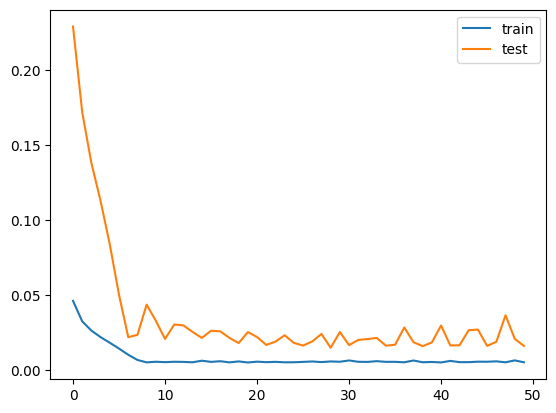

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

# design network
model = Sequential()   # Create a sequential model, i.e. a linear cascade model
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(train_Y.shape[1]))  # full connectivity layer
model.compile(loss='mae', optimizer='adam') 
# fit network
history = model.fit(train_X, train_Y, epochs=50, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### 评估模型

predictiony0 和 predictiony1分别表示close(t)和close(t+1)的预测结果

In [52]:
# Prediction of test set data using trained model
Yhat = model.predict(test_X)
Yhat

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[0.05889545, 0.05799979],
       [0.06009432, 0.05902759],
       [0.05953946, 0.0584478 ],
       ...,
       [0.62492883, 0.60618323],
       [0.63727766, 0.62032974],
       [0.6561686 , 0.63743836]], dtype=float32)

In [53]:
import numpy as np

predict_model = pd.DataFrame(Yhat, columns=['Yhat0', 'Yhat1'])
predict_model.insert(0, 'date', values.index[n_in:-n_out+1][n_train_days:])
print(predict_model)
test_Y_df = pd.DataFrame(test_Y, columns=['testY0', 'testY1'])
test_Y_df.insert(0, 'date', values.index[n_in:-n_out+1][n_train_days:])
print(test_Y_df)

           date     Yhat0     Yhat1
0    2019-07-03  0.058895  0.058000
1    2019-07-04  0.060094  0.059028
2    2019-07-05  0.059539  0.058448
3    2019-07-06  0.058928  0.057674
4    2019-07-07  0.057939  0.056162
...         ...       ...       ...
1697 2024-02-24  0.614249  0.596172
1698 2024-02-25  0.616947  0.595751
1699 2024-02-26  0.624929  0.606183
1700 2024-02-27  0.637278  0.620330
1701 2024-02-28  0.656169  0.637438

[1702 rows x 3 columns]
           date    testY0    testY1
0    2019-07-03  0.059665  0.055772
1    2019-07-04  0.055772  0.056513
2    2019-07-05  0.056513  0.056414
3    2019-07-06  0.056414  0.060216
4    2019-07-07  0.060216  0.061755
...         ...       ...       ...
1697 2024-02-24  0.619526  0.644377
1698 2024-02-25  0.644377  0.658583
1699 2024-02-26  0.658583  0.671853
1700 2024-02-27  0.671853  0.700608
1701 2024-02-28  0.700608  0.718084

[1702 rows x 3 columns]


In [54]:
predict_model.to_csv('../data/predict_model_results.csv')
test_Y_df.to_csv('../data/testY_rerults.csv')

In [55]:
from numpy import concatenate
import copy

# make a prediction
inv_Yhat = copy.deepcopy(Yhat)
print('close(t)', inv_Yhat[:,0].reshape(-1)[:10])
print('close(t+1)', inv_Yhat[:,1].reshape(-1)[:10])
print(Yhat.shape)
print(scaled[n_train_days:, :].shape)

inv_Yhat0 = concatenate((scaled[n_in:-n_out+1, :3][n_train_days:,:],
                         Yhat[:,:1], 
                         scaled[n_in:-n_out+1, 4:][n_train_days:,:]), axis=1)
inv_Yhat0 = scaler.inverse_transform(inv_Yhat0)
inv_Yhat0 = inv_Yhat0[:,3]

inv_Yhat1 = concatenate((scaled[n_in:-n_out+1, :3][n_train_days:,:],
                         Yhat[:,1:], 
                         scaled[n_in:-n_out+1, 4:][n_train_days:,:]), axis=1)
inv_Yhat1 = scaler.inverse_transform(inv_Yhat1)
inv_Yhat1 = inv_Yhat1[:,3]

predictiony0 = inv_Yhat0.reshape(-1)
predictiony1 = inv_Yhat1.reshape(-1)
originaly = values['close'].values[n_in:-n_out+1][n_train_days:]
x = values.index[n_in:-n_out+1][n_train_days:]
print(len(predictiony0), predictiony0[:10])
print(len(predictiony1), predictiony1[:10])
print(len(originaly), originaly[:10])
print(len(x), x[:10]) 
print(values.index)

close(t) [0.05889545 0.06009432 0.05953946 0.05892757 0.05793921 0.05893723
 0.05978266 0.06150108 0.06088853 0.05851995]
close(t+1) [0.05799979 0.05902759 0.0584478  0.05767427 0.05616193 0.05726027
 0.05906801 0.06133083 0.06045325 0.05759442]
(1702, 2)
(1706, 5)
1702 [297.592   303.30432 300.66055 297.74506 293.03577 297.79108 301.81937
 310.00723 307.08853 295.80286]
1702 [293.32443 298.22165 295.4591  291.77338 284.56747 289.8008  298.41425
 309.19598 305.01456 291.39294]
1702 [303.11823 284.41977 287.9779  287.50458 305.76273 313.15598 308.67667
 290.08618 268.4092  276.2384 ]
1702 DatetimeIndex(['2019-07-03', '2019-07-04', '2019-07-05', '2019-07-06',
               '2019-07-07', '2019-07-08', '2019-07-09', '2019-07-10',
               '2019-07-11', '2019-07-12'],
              dtype='datetime64[ns]', name='date', freq=None)
DatetimeIndex(['2017-03-01', '2017-03-02', '2017-03-03', '2017-03-04',
               '2017-03-05', '2017-03-06', '2017-03-07', '2017-03-08',
               

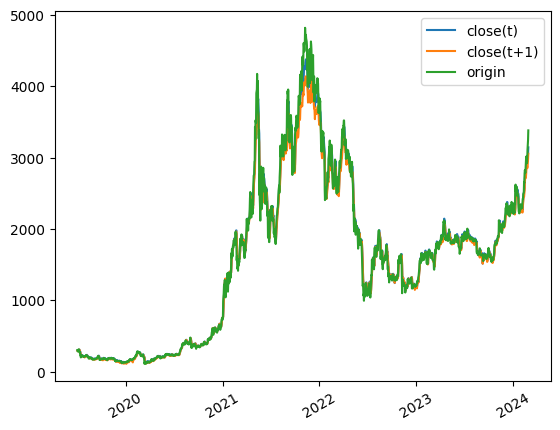

In [56]:
import matplotlib.pyplot as plt

plt.figure()
plt.xticks(rotation=30)
plt.plot(x, predictiony0, label='close(t)')
plt.plot(x, predictiony1, label='close(t+1)')
plt.plot(x, originaly, label='origin')
plt.legend()
plt.show()

In [57]:
import numpy as np
prediction = pd.DataFrame(np.concatenate((np.expand_dims(predictiony0, axis=1), np.expand_dims(predictiony1, axis=1)), axis=1), columns=['close(t)', 'close(t+1)'])
prediction.insert(0, 'date', x)
prediction.insert(1, 'origin', np.expand_dims(originaly, axis=1))

prediction

,date,origin,close(t),close(t+1)
0,2019-07-03,303.118225,297.592010,293.324432
1,2019-07-04,284.419769,303.304321,298.221649
2,2019-07-05,287.977905,300.660553,295.459106
3,2019-07-06,287.504578,297.745056,291.773376
4,2019-07-07,305.762726,293.035767,284.567474
...,...,...,...,...
1697,2024-02-24,2991.811279,2943.714355,2857.577637
1698,2024-02-25,3111.157227,2956.568604,2855.574707
1699,2024-02-26,3179.377441,2994.598877,2905.280762
1700,2024-02-27,3243.107910,3053.437988,2972.685303


In [58]:
prediction.to_csv('../data/prediction_result.csv')